### Blur Filter
- Averaging pixels inside a window

In [4]:
import numpy as np
from numba import cuda
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [5]:
# cc0 cat picture https://boudewijnhuijgens.getarchive.net/amp/media/maine-coon-black-and-white-cat-cat-animals-e1ddb4
catImage = Image.open("cat.jpg")
print("Image Size : ", catImage.size)

Image Size :  (1024, 1024)


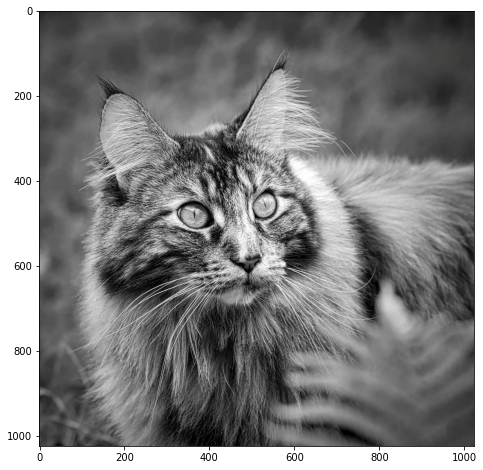

In [21]:
plt.figure(figsize=(8,8))
plt.imshow(catImage)
plt.show()

### Kernel Definition

In [7]:
@cuda.jit
def image_blur_kernel(input_image, output_image, window, N):
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x
    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    
    pixels = 0
    window_pixels_values = 0
    
    # make sure we are in image boundary
    if row < N and col < N:
        
        # loop over the window
        for i in range(-window, window+1):
            for j in range(-window, window+1):
                # make sure we are in image boundary
                if(row+i >= 0 and row+i < N and col+j >= 0 and col+j <N):
                    window_pixels_values += input_image[row + i, col+j]
                    pixels += 1
        # update pixel with the average        
        output_image[row, col] = window_pixels_values / pixels

### Prepare our image (one channel)

In [8]:
image_bw = np.array(catImage)[:,:,0]

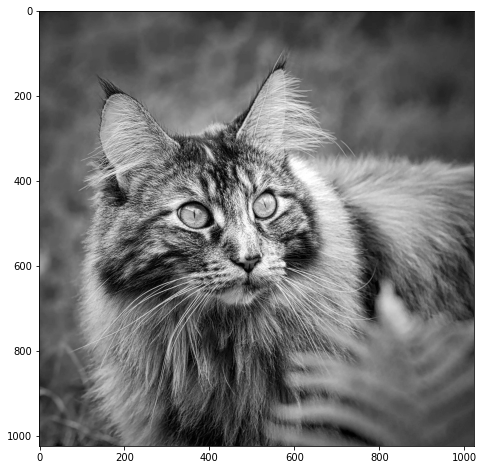

In [20]:
plt.figure(figsize=(8,8))
plt.imshow(image_bw, cmap='gray')
plt.show()

### Allocate memory on device

In [10]:
N = 1024
h_a = np.ascontiguousarray(image_bw,dtype=np.float32)
d_a = cuda.to_device(h_a)
d_b= cuda.device_array_like(d_a)

### Prepare threads

In [11]:
# 2d grid (64x64) => 4096 block
# 2d blocks (16x16) => 256 thread
n_blocks = (64, 64) # blocks per grid
n_threads = (16, 16) # threads per block
n_threads

(16, 16)

### Launch kernel

In [12]:
window = 5
N = 1024
image_blur_kernel[n_blocks, n_threads](d_a, d_b, window, N)
h_b = d_b.copy_to_host()

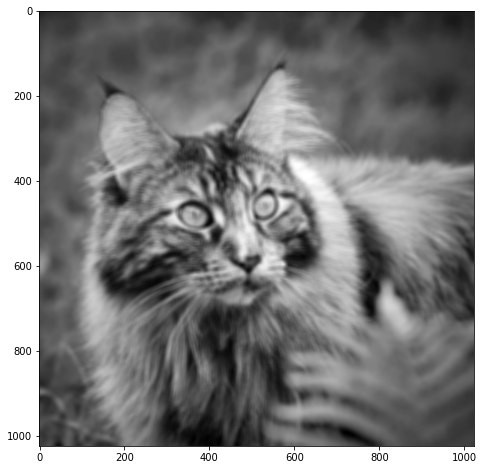

In [15]:
plt.figure(figsize=(8,8))
plt.imshow(h_b, cmap='gray')
plt.show()

In [16]:
window = 10
N = 1024

In [17]:
%%timeit -n5
image_blur_kernel[n_blocks, n_threads](d_a, d_b, window, N)

The slowest run took 11.95 times longer than the fastest. This could mean that an intermediate result is being cached.
79.6 µs ± 102 µs per loop (mean ± std. dev. of 7 runs, 5 loops each)


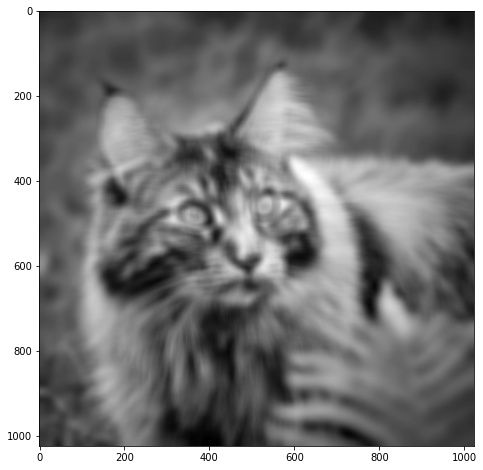

In [19]:
h_b = d_b.copy_to_host()
plt.figure(figsize=(8,8))
plt.imshow(h_b, cmap='gray')
plt.show()